In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [110]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

#latest date in database
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp_all_scores = session.query(Measurement.date, Measurement.prcp).\
                    order_by(Measurement.date.desc()).all()

#Retrieve the last 12 months of precipitation data and plot the results
prcp_data =session.query(Measurement.date, Measurement.prcp).\
            filter(Measurement.date >= year_ago).\
            order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
prcp_df = pd.DataFrame(prcp_data, columns=['date', 'precipitation']).sort_values('date')
prcp_df = prcp_df.set_index('date')
prcp_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


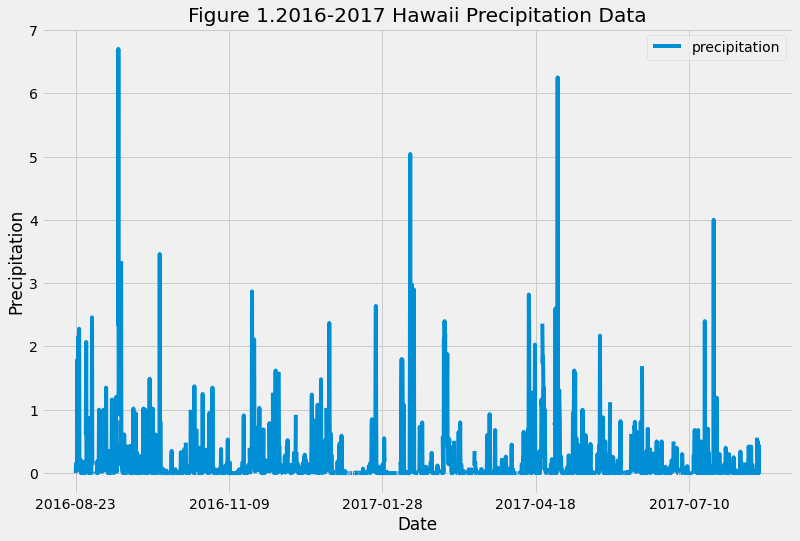

In [109]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(title="Figure 1.2016-2017 Hawaii Precipitation Data", figsize=(12, 8))
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.savefig("Images/Figure 1.2016-2017 Hawaii Precipitation Data.png")

In [35]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summ_stat = pd.DataFrame(prcp_df.describe())
summ_stat

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [36]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.station).count()
station_count

9

In [47]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station) \
                    .order_by(func.count(Measurement.station).desc()).all()

station_activity


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [49]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active = station_activity[0][0]

stats = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]

temp_info = session.query(*stats).\
            filter(Measurement.station == most_active).all()

print(f"The most active station is {most_active}, with temperature readings as follows: min, max, average = {temp_info}.")


The most active station is USC00519281, with temperature readings as follows: min, max, average = [(54.0, 85.0, 71.66378066378067)].


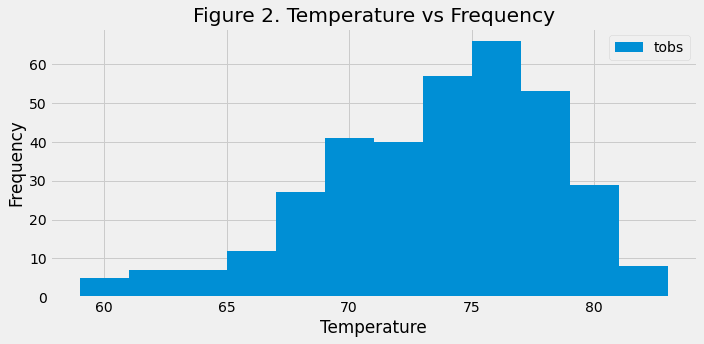

In [55]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
max_observe_station = session.query(Measurement.tobs).filter(Measurement.station == most_active) \
                .filter(Measurement.date >= year_ago).all()
tobs_df = pd.DataFrame(max_observe_station, columns=['tobs'])

tobs_df.plot(kind='hist', bins=12, title="Figure 2. Temperature vs Frequency", figsize=(10,5))
plt.xlabel("Temperature")
plt.tight_layout()
plt.savefig("Images/Figure 2. Temperature vs Frequency.png")
plt.show()

## Bonus Challenge Assignment

In [56]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [58]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip = calc_temps("2017-05-29","2017-06-10")
trip

trip_df = pd.DataFrame(trip, columns=["TMIN", "TAVG", "TMAX"])
trip_df

,TMIN,TAVG,TMAX
0,71.0,77.3125,81.0


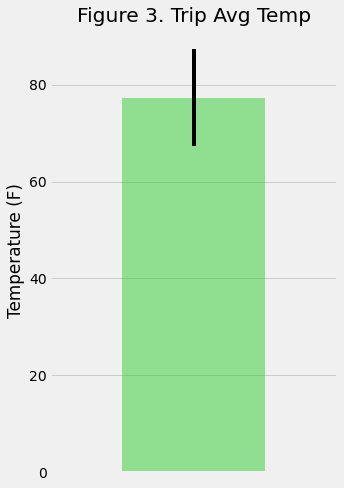

In [61]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df.plot.bar(y="TAVG", yerr=(trip_df["TMAX"] - trip_df["TMIN"]),
                title='Figure 3. Trip Avg Temp',
                color='limegreen',
                alpha=0.5,
                figsize=(5,7),
                legend=None)
plt.xticks([])
plt.ylabel("Temperature (F)")
plt.tight_layout()
plt.savefig("Images/Figure 3. Trip Avg Temp.png")
plt.show()

In [81]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def totalRainfall(start_date, end_date):
    return session.query(Measurement.station,
                         Station.name,
                         func.sum(Measurement.prcp),
                         Station.latitude,
                         Station.longitude,
                         Station.elevation).\
                            group_by(Measurement.station).\
                            join(Station, Measurement.station == Station.station).\
                            filter(Measurement.date >= start_date).\
                            filter(Measurement.date <= end_date).\
                            order_by(func.sum(Measurement.prcp).desc()).all()

rainfall = totalRainfall("2017-05-29","2017-06-10")
rainfall

[('USC00519281',
  'WAIHEE 837.5, HI US',
  2.7600000000000002,
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00513117', 'KANEOHE 838.1, HI US', 1.05, 21.4234, -157.8015, 14.6),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  0.96,
  21.5213,
  -157.8374,
  7.0),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  0.85,
  21.3331,
  -157.8025,
  152.4),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  0.39,
  21.33556,
  -157.71139,
  19.5),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 0.34, 21.2716, -157.8168, 3.0),
 ('USC00517948', 'PEARL CITY, HI US', None, 21.3934, -157.9751, 11.9)]

In [84]:
# creating the Numpy array 
rainfall_df = pd.DataFrame(np.array(rainfall))
rainfall_df = rainfall_df.rename(columns={0: "Station", 
                                          1: "Location", 
                                          2: "Total Precipitation", 
                                          3: "Latitude", 
                                          4: "Longitude", 
                                          5: "Elevation"})

rainfall_df

,Station,Location,Total Precipitation,Latitude,Longitude,Elevation
0,USC00519281,"WAIHEE 837.5, HI US",2.76,21.4517,-157.849,32.9
1,USC00513117,"KANEOHE 838.1, HI US",1.05,21.4234,-157.802,14.6
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.96,21.5213,-157.837,7
3,USC00516128,"MANOA LYON ARBO 785.2, HI US",0.85,21.3331,-157.803,152.4
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.39,21.3356,-157.711,19.5
5,USC00519397,"WAIKIKI 717.2, HI US",0.34,21.2716,-157.817,3
6,USC00517948,"PEARL CITY, HI US",None,21.3934,-157.975,11.9


In [85]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [98]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date

start_date = "2019-01-31"
end_date = "2019-02-10"

start_num = int(start_date[-2:])
end_num = int(end_date[-2:])
duration = end_num - start_num + 1

start_date = dt.datetime.strptime(start_date, '%Y-%m-%d')

list_date = [dt.datetime.strftime(start_date + dt.timedelta(days = x), '%m-%d') 
            for x in range(0, duration)]

#calculate normals for each date
normals = [daily_normals(date) for date in list_date]

normals

[]

In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
